# LLM in-context learning experiment - Llama 3 70B (work)
Our previous in-context learning experiment showed that the method was very effective, achieving high levels of accuracy compared to its "vanilla" model and scoring well on virtually all metrics. However, we also have seen that the Llama 3 70B model performs better than 8B in-context learning without *any* prompt engineering, fine-tuning, or in-context learning whatsoever!

Therefore, it seems plausible to imagine that we could increase the accuracy with in-context learning, although perhaps not as dramatically as with Llama 3 8B.

(Please see separate notebook for full analysis)

In [1]:
from groq import Groq
import pandas as pd
import time

In [2]:
client = Groq(
    api_key="",
)

### Creating the prompt and labeling function

**Computer Science:**

```
Task: Classify each abstract as Computer Science (CS) or non-Computer Science (non-CS). Please only respond "CS" if you are *very* confident that it is a CS abstract; otherwise, respond "non-CS". Use the given examples as a guide.

Context: Computer Science abstracts often discuss subjects such as algorithms, machine learning, software development, computer systems, and data science. In contrast, non-CS abstracts address topics outside of these areas, like biology, statistics, physics, and finance.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: non-CS
Reason: The subject is physics, not computer science.

Example 2:
Abstract: "Polycrystalline diamond coatings have been grown on cemented carbide substrates with different aspect ratios by a microwave plasma CVD in methane-hydrogen gas mixtures. To protect the edges of the substrates from non-uniform heating due to the plasma edge effect, a special plateholder with pockets for group growth has been used. The difference in heights of the substrates and plateholder, and its influence on the diamond film mean grain size, growth rate, phase composition and stress was investigated. The substrate temperature range, within which uniform diamond films are produced with good adhesion, is determined. The diamond-coated cutting inserts produced at optimized process exhibited a reduction of cutting force and wear resistance by a factor of two, and cutting efficiency increase by 4.3 times upon turning A390 Al-Si alloy as compared to performance of uncoated tools."
Classification: non-CS
Reason: The subject is physics, not computer science.

Example 3:
Abstract: "Machine learning is finding increasingly broad application in the physical sciences. This most often involves building a model relationship between a dependent, measurable output and an associated set of controllable, but complicated, independent inputs. We present a tutorial on current techniques in machine learning -- a jumping-off point for interested researchers to advance their work. We focus on deep neural networks with an emphasis on demystifying deep learning. We begin with background ideas in machine learning and some example applications from current research in plasma physics. We discuss supervised learning techniques for modeling complicated functions, beginning with familiar regression schemes, then advancing to more sophisticated deep learning methods. We also address unsupervised learning and techniques for reducing the dimensionality of input spaces. Along the way, we describe methods for practitioners to help ensure that their models generalize from their training data to as-yet-unseen test data.",
Classification: CS
Reason: The abstract discusses machine learning, which is a computer science concept.  

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: non-CS
Reason: The subject is mathematics, not computer science; abstracts must explicitly discuss computer science topics, even if the math discussed could be applicable to computer science.

Now, classify the following abstract:

Abstract: {abstract}
Classification:
```

In [7]:
def create_prompt_cs(abstract):
    prompt = f'''Task: Classify each abstract as Computer Science (CS) or non-Computer Science (non-CS). Please only respond "CS" if you are *very* confident that it is a CS abstract; otherwise, respond "non-CS". Use the given examples as a guide.

Context: Computer Science abstracts often discuss subjects such as algorithms, machine learning, software development, computer systems, and data science. In contrast, non-CS abstracts address topics outside of these areas, like biology, statistics, physics, and finance.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: non-CS
Reason: The subject is physics, not computer science.

Example 2:
Abstract: "Polycrystalline diamond coatings have been grown on cemented carbide substrates with different aspect ratios by a microwave plasma CVD in methane-hydrogen gas mixtures. To protect the edges of the substrates from non-uniform heating due to the plasma edge effect, a special plateholder with pockets for group growth has been used. The difference in heights of the substrates and plateholder, and its influence on the diamond film mean grain size, growth rate, phase composition and stress was investigated. The substrate temperature range, within which uniform diamond films are produced with good adhesion, is determined. The diamond-coated cutting inserts produced at optimized process exhibited a reduction of cutting force and wear resistance by a factor of two, and cutting efficiency increase by 4.3 times upon turning A390 Al-Si alloy as compared to performance of uncoated tools."
Classification: non-CS
Reason: The subject is physics, not computer science.

Example 3:
Abstract: "Machine learning is finding increasingly broad application in the physical sciences. This most often involves building a model relationship between a dependent, measurable output and an associated set of controllable, but complicated, independent inputs. We present a tutorial on current techniques in machine learning -- a jumping-off point for interested researchers to advance their work. We focus on deep neural networks with an emphasis on demystifying deep learning. We begin with background ideas in machine learning and some example applications from current research in plasma physics. We discuss supervised learning techniques for modeling complicated functions, beginning with familiar regression schemes, then advancing to more sophisticated deep learning methods. We also address unsupervised learning and techniques for reducing the dimensionality of input spaces. Along the way, we describe methods for practitioners to help ensure that their models generalize from their training data to as-yet-unseen test data.",
Classification: CS
Reason: The abstract discusses machine learning, which is a computer science concept.  

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: non-CS
Reason: The subject is mathematics, not computer science; abstracts must explicitly discuss computer science topics, even if the math discussed could be applicable to computer science.

Now, classify the following abstract:

Abstract: {abstract}
Classification: '''
    return prompt

In [26]:
def label_abstract_cs(x):
    prompt = create_prompt_cs(x)
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama3-70b-8192",
    )
    resp = chat_completion.choices[0].message.content
    
    print(f"Message: {resp}")
    
    time.sleep(10) # Added to conform with rate limits
    if ('non-CS' in resp[:10]) or ('Non-CS' in resp[:10]) : # Restrict to only beginning
        return 0
    return 1

### Import data and run the model

In [5]:
df = pd.read_csv("data/test_set.csv")
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,475,Selecting optimal minimum spanning trees that ...,Choi et. al (2011) introduced a minimum span...,1,0,1,0,0,0
1,11242,A Markov Chain Model for the Cure Rate of Non-...,A Markov-chain model is developed for the pu...,0,0,0,1,0,1
2,649,On Popov's formula involving the Von Mangoldt ...,We offer a generalization of a formula of Po...,0,0,1,0,0,0
3,15325,Retirement spending and biological age,We solve a lifecycle model in which the cons...,0,0,0,0,0,1
4,1529,Social Network based Short-Term Stock Trading ...,This paper proposes a novel adaptive algorit...,1,0,0,0,0,1


In [10]:
df['Llama3_70B_IC_CS'][:300] = df['ABSTRACT'][:300].apply(label_abstract_cs)

Message: CS
Message: non-CS
Message: non-CS
Message: non-CS
Message: CS
Message: non-CS
Message: non-CS
Message: non-CS
Message: CS
Message: non-CS
Message: non-CS
Message: CS
Message: non-CS
Message: non-CS
Message: non-CS
Message: CS
Message: CS
Message: CS
Message: non-CS

Reason: The abstract discusses astrophysics and modifications to gravity, which are topics outside of computer science. Although it mentions "N-body simulations", which could be a computer science-related topic, the focus of the abstract is on the scientific application of these simulations, not on the algorithms or computational methods themselves.
Message: non-CS
Message: CS
Message: non-CS
Message: non-CS
Message: CS

Reason: The abstract discusses a novel framework for stock prediction using ensemble models and online update strategies, which are computer science concepts. The abstract also mentions domain knowledge, feature sets, and misclassification error, which are all related to machine learning and data 

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\1538850151.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Llama3_70B_IC_CS'][:300] = df['ABSTRACT'][:300].apply(label_abstract_cs)
C:\Users\aharve\AppData\Local\Temp\ipykernel_19004

In [28]:
df['Llama3_70B_IC_CS'][300:600] = df['ABSTRACT'][300:600].apply(label_abstract_cs)

Message: CS
Message: CS

Reason: The abstract discusses integer programming, linear programming, and polytope integrality, which are all concepts in computer science, specifically in the field of algorithms and optimization. The paper also mentions solving the IP model in polynomial time, which is a fundamental concept in computer science.
Message: non-CS
Message: non-CS
Message: non-CS
Message: non-CS
Message: non-CS
Message: CS
Message: non-CS

Reason: The abstract discusses the dynamics of the sine-Gordon equation, magnetization localized waves, and perturbation theory, which are topics in physics and mathematics, not computer science. There is no explicit mention of computer science concepts, algorithms, or applications.
Message: non-CS
Message: CS

Reason: The abstract discusses communication systems, energy harvesting, and information decoding, which are all topics related to computer science, particularly in the areas of wireless communications and energy-efficient systems. The 

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\3618881333.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Llama3_70B_IC_CS'][300:600] = df['ABSTRACT'][300:600].apply(label_abstract_cs)
C:\Users\aharve\AppData\Local\Temp\ipykernel

In [31]:
df['Llama3_70B_IC_CS'][600:900] = df['ABSTRACT'][600:900].apply(label_abstract_cs)

Message: non-CS
Message: non-CS
Message: CS
Message: non-CS
Message: CS
Message: CS
Message: non-CS
Message: CS
Message: CS
Message: CS
Message: non-CS
Message: CS
Message: CS
Message: CS
Message: non-CS
Message: non-CS
Message: CS

Reason: The abstract explicitly discusses Artificial General Intelligence (AGI), which is a computer science concept, and mentions bio-inspired software and hardware, indicating a strong connection to computer science.
Message: CS
Message: CS

Reason: The abstract discusses stochastic gradient descent (SGD), which is a machine learning concept, and proposes a scalable inferential procedure for SGD, which is a computer science topic.
Message: CS
Message: non-CS
Message: CS
Message: non-CS
Message: non-CS
Message: CS
Message: CS
Message: non-CS 

Reason: The abstract discusses the history of mathematics and the development of a mathematical concept (involution) in the 17th century, which is not a computer science topic.
Message: CS
Message: non-CS
Message: no

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\457848968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Llama3_70B_IC_CS'][600:900] = df['ABSTRACT'][600:900].apply(label_abstract_cs)


In [32]:
df['Llama3_70B_IC_CS'][900:1054] = df['ABSTRACT'][900:1054].apply(label_abstract_cs)

Message: non-CS 

Reason: This abstract discusses gene regulatory networks, biological processes, and statistical tools, which are topics in biology and mathematics, not computer science. Although it mentions simulation and algorithms, the focus is on biological and mathematical concepts, not computer science topics like software development, algorithms, or data science.
Message: non-CS 

Reason: The subject is physics, not computer science. Although the abstract discusses equations of motion and dynamics, which could be applicable to computer simulations, it does not explicitly discuss computer science topics like algorithms, machine learning, or software development.
Message: CS

Reason: The abstract discusses deep-learning methods, specifically a novel Deep Neural Network called Deep SNP, and its application to life science problems such as predicting genomic breakpoints and copy number alterations. This is a computer science concept, specifically in the area of machine learning and

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\1021219959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Llama3_70B_IC_CS'][900:1054] = df['ABSTRACT'][900:1054].apply(label_abstract_cs)


In [33]:
df.to_csv("cs_icl.csv")

In [19]:
df.loc[102]["Llama3_70B_IC_CS"] = 0

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\1424390858.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[102]["Llama3_70B_IC_CS"] = 0


In [19]:
df_labeled.to_csv("data/llama3_70b_icl_experiment.csv")

<Axes: >

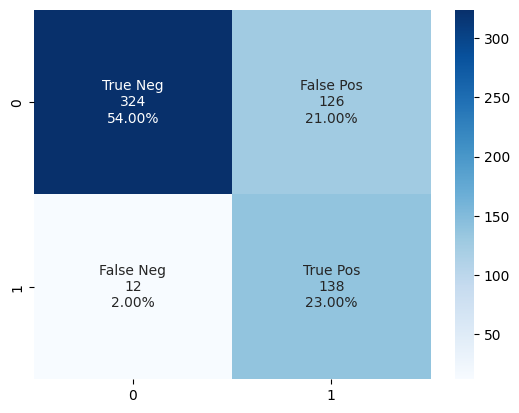

In [29]:
# Source: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(df[:600]['Computer Science'], df[:600]['Llama3_70B_IC_CS'])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

My hunch: Groq's Llama 3 70B is some quantized version which results in worse performance on tasks like these. In that case, non-quantized Llama 3 8B with ICL might have better accuracy than quantized Llama 3 70B.

**Mathematics**

We first need to retrieve the articles to be used for the ICL prompt. Similar to the CS approach, we choose a sample of the last 15 abstracts which are math articles and construct our prompt with 3 non-math articles and 1 math article (since the model also has a tendency to assign false positives).

In [43]:
full_set = pd.read_csv("data/text-classification-train.csv")

In [46]:
full_set[-15:]

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
20957,20958,Elliptic Hall algebra on $\mathbb{F}_1$,We construct Hall algebra of elliptic curve ...,0,0,1,0,0,0
20958,20959,Approximate Bayesian inference with queueing n...,Queueing networks are systems of theoretical...,1,0,0,1,0,0
20959,20960,Universal features of price formation in finan...,Using a large-scale Deep Learning approach a...,0,0,0,1,0,1
20960,20961,A New Tracking Algorithm for Multiple Colloida...,"In this paper, we propose a new algorithm ba...",0,1,0,0,0,0
20961,20962,Critical Percolation Without Fine Tuning on th...,We present numerical evidence that most two-...,0,1,0,0,0,0
20962,20963,Low-luminosity stellar wind accretion onto neu...,Features and applications of quasi-spherical...,0,1,0,0,0,0
20963,20964,Faithful Inversion of Generative Models for Ef...,Inference amortization methods share informa...,1,0,0,1,0,0
20964,20965,A social Network Analysis of the Operations Re...,We study the U.S. Operations Research/Indust...,1,0,0,1,0,0
20965,20966,One-sample aggregate data meta-analysis of med...,An aggregate data meta-analysis is a statist...,0,0,0,1,0,0
20966,20967,QuickCast: Fast and Efficient Inter-Datacenter...,Large inter-datacenter transfers are crucial...,1,0,0,0,0,0


In [51]:
full_set[-15:][full_set["Mathematics"] == 1]["ABSTRACT"].iloc[0]

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\1073165436.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  full_set[-15:][full_set["Mathematics"] == 1]["ABSTRACT"].iloc[0]


'  We construct Hall algebra of elliptic curve over $\\mathbb{F}_1$ using the\ntheory of monoidal scheme due to Deitmar and the theory of Hall algebra for\nmonoidal representations due to Szczesny. The resulting algebra is shown to be\na specialization of elliptic Hall algebra studied by Burban and Schiffmann.\nThus our algebra is isomorphic to the skein algebra for torus by the recent\nwork of Morton and Samuelson.\n'

In [55]:
full_set[-15:]["ABSTRACT"].iloc[1]

'  Queueing networks are systems of theoretical interest that give rise to\ncomplex families of stochastic processes, and find widespread use in the\nperformance evaluation of interconnected resources. Yet, despite their\nimportance within applications, and in comparison to their counterpart\nstochastic models in genetics or mathematical biology, there exist few relevant\napproaches for transient inference and uncertainty quantification tasks in\nthese systems. This is a consequence of strong computational impediments and\ndistinctive properties of the Markov jump processes induced by queueing\nnetworks. In this paper, we offer a comprehensive overview of the inferential\nchallenge and its comparison to analogue tasks within related mathematical\ndomains. We then discuss a model augmentation over an approximating network\nsystem, and present a flexible and scalable variational Bayesian framework,\nwhich is targeted at general-form open and closed queueing systems, with varied\nservice 

In [59]:
full_set[-15:]["ABSTRACT"].iloc[8]

'  An aggregate data meta-analysis is a statistical method that pools the\nsummary statistics of several selected studies to estimate the outcome of\ninterest. When considering a continuous outcome, typically each study must\nreport the same measure of the outcome variable and its spread (e.g., the\nsample mean and its standard error). However, some studies may instead report\nthe median along with various measures of spread. Recently, the task of\nincorporating medians in meta-analysis has been achieved by estimating the\nsample mean and its standard error from each study that reports a median in\norder to meta-analyze the means. In this paper, we propose two alternative\napproaches to meta-analyze data that instead rely on medians. We systematically\ncompare these approaches via simulation study to each other and to methods that\ntransform the study-specific medians and spread into sample means and their\nstandard errors. We demonstrate that the proposed median-based approaches\nperf

In [60]:
full_set[-15:]["ABSTRACT"].iloc[4]

'  We present numerical evidence that most two-dimensional surface states of a\nbulk topological superconductor (TSC) sit at an integer quantum Hall plateau\ntransition. We study TSC surface states in class CI with quenched disorder.\nLow-energy (finite-energy) surface states were expected to be critically\ndelocalized (Anderson localized). We confirm the low-energy picture, but find\ninstead that finite-energy states are also delocalized, with universal\nstatistics that are independent of the TSC winding number, and consistent with\nthe spin quantum Hall plateau transition (percolation).\n'

*Constructing the prompt*

```
Task: Classify each abstract as Math (Math) or non-Math (non-Math). Please only respond with "Math" if you are *very* confident that it is a mathematics abstract; otherwise, respond "non-Math". Use the given examples as a guide.

Context: Mathematics abstracts often discuss topics such as algebra, calculus, number theory, geometry, mathematical modeling, and pure or applied mathematics. Non-Mathematics abstracts cover a wide range of other fields like biology, medicine, physics, computer science, environmental science, etc.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: non-Math
Reason: The subject is physics, not mathematics.

Example 2:
Abstract: "Queueing networks are systems of theoretical interest that give rise to complex families of stochastic processes, and find widespread use in the performance evaluation of interconnected resources. Yet, despite their importance within applications, and in comparison to their counterpart stochastic models in genetics or mathematical biology, there exist few relevant approaches for transient inference and uncertainty quantification tasks in these systems. This is a consequence of strong computational impediments and distinctive properties of the Markov jump processes induced by queueing networks. In this paper, we offer a comprehensive overview of the inferential challenge and its comparison to analogue tasks within related mathematical domains."
Classification: non-Math
Reason: While the abstract mentions some mathematical concepts, the abstract's focus on queueing networks means that it is a computer science and statistics article, not a mathematics article.

Example 3:
Abstract: "An aggregate data meta-analysis is a statistical method that pools the summary statistics of several selected studies to estimate the outcome of interest. When considering a continuous outcome, typically each study must report the same measure of the outcome variable and its spread (e.g., the sample mean and its standard error). However, some studies may instead report the median along with various measures of spread. Recently, the task of incorporating medians in meta-analysis has been achieved by estimating the sample mean and its standard error from each study that reports a median in order to meta-analyze the means. In this paper, we propose two alternative approaches to meta-analyze data that instead rely on medians. We systematically compare these approaches via simulation study to each other and to methods that transform the study-specific medians and spread into sample means and their standard errors.",
Classification: non-Math
Reason: The subject is statistics, not mathematics.

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: Math
Reason: The abstract discusses algebra and key geometric theories, which are aspects of mathematics.

Now, classify the following abstract:

Abstract: {abstract}
Classification:
```

In [63]:
def create_prompt_math(abstract):
    prompt = f'''Task: Classify each abstract as Math (Math) or non-Math (non-Math). Please only respond with "Math" if you are *very* confident that it is a mathematics abstract; otherwise, respond "non-Math". Use the given examples as a guide.

Context: Mathematics abstracts often discuss topics such as algebra, calculus, number theory, geometry, mathematical modeling, and pure or applied mathematics. Non-Mathematics abstracts cover a wide range of other fields like biology, medicine, physics, computer science, environmental science, etc.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: non-Math
Reason: The subject is physics, not mathematics.

Example 2:
Abstract: "Queueing networks are systems of theoretical interest that give rise to complex families of stochastic processes, and find widespread use in the performance evaluation of interconnected resources. Yet, despite their importance within applications, and in comparison to their counterpart stochastic models in genetics or mathematical biology, there exist few relevant approaches for transient inference and uncertainty quantification tasks in these systems. This is a consequence of strong computational impediments and distinctive properties of the Markov jump processes induced by queueing networks. In this paper, we offer a comprehensive overview of the inferential challenge and its comparison to analogue tasks within related mathematical domains."
Classification: non-Math
Reason: While the abstract mentions some mathematical concepts, the abstract's focus on queueing networks means that it is a computer science and statistics article, not a mathematics article.

Example 3:
Abstract: "An aggregate data meta-analysis is a statistical method that pools the summary statistics of several selected studies to estimate the outcome of interest. When considering a continuous outcome, typically each study must report the same measure of the outcome variable and its spread (e.g., the sample mean and its standard error). However, some studies may instead report the median along with various measures of spread. Recently, the task of incorporating medians in meta-analysis has been achieved by estimating the sample mean and its standard error from each study that reports a median in order to meta-analyze the means. In this paper, we propose two alternative approaches to meta-analyze data that instead rely on medians. We systematically compare these approaches via simulation study to each other and to methods that transform the study-specific medians and spread into sample means and their standard errors.",
Classification: non-Math
Reason: The subject is statistics, not mathematics.

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: Math
Reason: The abstract discusses algebra and key geometric theories, which are aspects of mathematics.

Now, classify the following abstract:

Abstract: {abstract}
Classification: '''
    return prompt

In [64]:
def label_abstract_math(x):
    prompt = create_prompt_math(x)
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama3-70b-8192",
    )
    resp = chat_completion.choices[0].message.content
    
    print(f"Message: {resp}")
    
    time.sleep(10) # Added to conform with rate limits
    if ('non-Math' in resp[:10]) or ('Non-Math' in resp[:10]) : # Restrict to only beginning
        return 0
    return 1

In [81]:
df['Llama3_70B_IC_Math'][0:300] = df['ABSTRACT'][0:300].apply(label_abstract_math)

Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math

Reason: The abstract discusses a method for performing approximate inference in complex probabilistic models, which

KeyError: 'Llama3_70B_IC_Math'

In [82]:
df['Llama3_70B_IC_Math'][300:600] = df['ABSTRACT'][300:600].apply(label_abstract_math)

Message: Math
Message: Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math

Reason: Although the abstract mentions some mathematical concepts like modeling and equations, the subject is actually biology/entomology and epidemiology, and the focus is on designing control strategies for mosquito population elimination, which is not a mathematics paper.
Message: Math
Message: Math
Message: non-Math
Message: Math
Message: non-Math
Message: Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
M

KeyError: 'Llama3_70B_IC_Math'

In [83]:
df['Llama3_70B_IC_Math'][600:900] = df['ABSTRACT'][600:900].apply(label_abstract_math)

Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: Math
Message: Math
Message: non-Math
Message: Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: Math
Message: non-Math
Message: Math


KeyError: 'Llama3_70B_IC_Math'

In [87]:
df['Llama3_70B_IC_Math'][900:1054] = df['ABSTRACT'][900:1054].apply(label_abstract_math)

Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: Non-Math
Message: non-Math
Message: Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Math
Message: non-Mat

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\4240533456.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Llama3_70B_IC_Math'][900:1054] = df['ABSTRACT'][900:1054].apply(label_abstract_math)
C:\Users\aharve\AppData\Local\Temp\ipy

In [88]:
df.to_csv("math_llama370b_icl.csv")

**Quantitative Biology**

Since there is no quantitative biology article in the last 15, we expand our sample to the last 500 to retrieve a QB article which is not in the test set.

In [71]:
full_set[-500:][full_set["Quantitative Biology"] == 1]

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\869583037.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  full_set[-500:][full_set["Quantitative Biology"] == 1]


,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
20482,20483,The PomXYZ Proteins Self-Organize on the Bacte...,Cell division site positioning is precisely ...,0,0,0,0,1,0
20597,20598,Beta-rhythm oscillations and synchronization t...,"Despite their significant functional roles, ...",0,0,0,0,1,0
20624,20625,Towards a Science of Mind,The ancient mind/body problem continues to b...,1,0,0,0,1,0
20644,20645,A metric model for the functional architecture...,The purpose of this work is to construct a m...,0,0,0,0,1,0
20691,20692,Discovering the effect of nonlocal payoff calc...,The classical idea of evolutionarily stable ...,0,0,0,0,1,0
20742,20743,Bioinformatics and Medicine in the Era of Deep...,Many of the current scientific advances in t...,0,0,0,1,1,0
20755,20756,An integration of fast alignment and maximum-l...,Motivation: Cellular Electron CryoTomography...,0,0,0,1,1,0
20855,20856,Phase-type distributions in population genetics,Probability modelling for DNA sequence evolu...,0,0,0,1,1,0


In [75]:
full_set.iloc[20855]["ABSTRACT"]

'  Probability modelling for DNA sequence evolution is well established and\nprovides a rich framework for understanding genetic variation between samples\nof individuals from one or more populations. We show that both classical and\nmore recent models for coalescence (with or without recombination) can be\ndescribed in terms of the so-called phase-type theory, where complicated and\ntedious calculations are circumvented by the use of matrices. The application\nof phase-type theory consists of describing the stochastic model as a Markov\nmodel by appropriately setting up a state space and calculating the\ncorresponding intensity and reward matrices. Formulae of interest are then\nexpressed in terms of these aforementioned matrices. We illustrate this by a\nfew examples calculating the mean, variance and even higher order moments of\nthe site frequency spectrum in the multiple merger coalescent models, and by\nanalysing the mean and variance for the number of segregating sites for\nmult

*Creating the prompt*

```
Task: Classify each abstract as quantitative biology (QB) or non-QB (non-QB). Please only respond with "QB" if you are *very* confident that it is a quantitative biology abstract; otherwise, respond "non-QB". Use the given examples as a guide.

Context: Quantitative Biology abstracts often discuss topics such as computational biology, bioinformatics, systems biology, mathematical modeling of biological systems, biostatistics, and quantitative analysis of biological data. Non-Quantitative Biology abstracts cover a wide range of other fields like mathematics, non-biological computer science, chemistry, physics, finance, etc.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: non-QB
Reason: The subject is physics, not quantitative biology.

Example 2:
Abstract: "Queueing networks are systems of theoretical interest that give rise to complex families of stochastic processes, and find widespread use in the performance evaluation of interconnected resources. Yet, despite their importance within applications, and in comparison to their counterpart stochastic models in genetics or mathematical biology, there exist few relevant approaches for transient inference and uncertainty quantification tasks in these systems. This is a consequence of strong computational impediments and distinctive properties of the Markov jump processes induced by queueing networks. In this paper, we offer a comprehensive overview of the inferential challenge and its comparison to analogue tasks within related mathematical domains."
Classification: non-QB
Reason: While the abstract mentions mathematical biology, the abstract's main focus on queueing networks means that it is a computer science and statistics article, not a quantitative biology article.

Example 3:
Abstract: "Probability modelling for DNA sequence evolution is well established and provides a rich framework for understanding genetic variation between samples of individuals from one or more populations. We show that both classical and more recent models for coalescence (with or without recombination) can be described in terms of the so-called phase-type theory, where complicated and tedious calculations are circumvented by the use of matrices. The application of phase-type theory consists of describing the stochastic model as a Markov model by appropriately setting up a state space and calculating the corresponding intensity and reward matrices.",
Classification: QB
Reason: The abstract discusses a statistical approach to DNA sequence evolution, which is a biological concept.

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: non-QB
Reason: The abstract discusses algebra and key geometric theories, which are aspects of mathematics, not quantitative biology.

Now, classify the following abstract:

Abstract: {abstract}
Classification:
```

In [76]:
def create_prompt_qb(abstract):
    prompt = f'''Task: Classify each abstract as quantitative biology (QB) or non-QB (non-QB). Please only respond with "QB" if you are *very* confident that it is a quantitative biology abstract; otherwise, respond "non-QB". Use the given examples as a guide.

Context: Quantitative Biology abstracts often discuss topics such as computational biology, bioinformatics, systems biology, mathematical modeling of biological systems, biostatistics, and quantitative analysis of biological data. Non-Quantitative Biology abstracts cover a wide range of other fields like mathematics, non-biological computer science, chemistry, physics, finance, etc.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: non-QB
Reason: The subject is physics, not quantitative biology.

Example 2:
Abstract: "Queueing networks are systems of theoretical interest that give rise to complex families of stochastic processes, and find widespread use in the performance evaluation of interconnected resources. Yet, despite their importance within applications, and in comparison to their counterpart stochastic models in genetics or mathematical biology, there exist few relevant approaches for transient inference and uncertainty quantification tasks in these systems. This is a consequence of strong computational impediments and distinctive properties of the Markov jump processes induced by queueing networks. In this paper, we offer a comprehensive overview of the inferential challenge and its comparison to analogue tasks within related mathematical domains."
Classification: non-QB
Reason: While the abstract mentions mathematical biology, the abstract's main focus on queueing networks means that it is a computer science and statistics article, not a quantitative biology article.

Example 3:
Abstract: "Probability modelling for DNA sequence evolution is well established and provides a rich framework for understanding genetic variation between samples of individuals from one or more populations. We show that both classical and more recent models for coalescence (with or without recombination) can be described in terms of the so-called phase-type theory, where complicated and tedious calculations are circumvented by the use of matrices. The application of phase-type theory consists of describing the stochastic model as a Markov model by appropriately setting up a state space and calculating the corresponding intensity and reward matrices.",
Classification: QB
Reason: The abstract discusses a statistical approach to DNA sequence evolution, which is a biological concept.

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: non-QB
Reason: The abstract discusses algebra and key geometric theories, which are aspects of mathematics, not quantitative biology.

Now, classify the following abstract:

Abstract: {abstract}
Classification: '''
    return prompt

In [77]:
def label_abstract_qb(x):
    prompt = create_prompt_qb(x)
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama3-70b-8192",
    )
    resp = chat_completion.choices[0].message.content
    
    print(f"Message: {resp}")
    
    time.sleep(10) # Added to conform with rate limits
    if ('non-QB' in resp[:10]) or ('Non-QB' in resp[:10]) : # Restrict to only beginning
        return 0
    return 1

In [96]:
df['Llama3_70B_IC_QB'][0:300] = df['ABSTRACT'][0:300].apply(label_abstract_qb)

Message: QB
Message: non-QB
Message: non-QB
Message: non-QB

Reason: The abstract discusses a lifecycle model, mortality rates, and economic decisions, which are aspects of economics, not quantitative biology. Although it mentions biological age and biomarkers, the focus is on economic modeling and decision-making, rather than biological systems or quantitative analysis of biological data.
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB

Reason: The abstract discusses a novel adaptive lo

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\438185686.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Llama3_70B_IC_QB'][0:300] = df['ABSTRACT'][0:300].apply(label_abstract_qb)
C:\Users\aharve\AppData\Local\Temp\ipykernel_1900

In [97]:
df['Llama3_70B_IC_QB'][300:600] = df['ABSTRACT'][300:600].apply(label_abstract_qb)

Message: non-QB
Message: non-QB
Message: QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB 

Reason: The abstract discusses decision-making, subjective expected utility theory, and quantum-theoretic frameworks, which are aspects of economics, psychology, and quantum theory, not quantitative biology.
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: QB
Message: QB
Message: non-QB
Message: n

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\3556409281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Llama3_70B_IC_QB'][300:600] = df['ABSTRACT'][300:600].apply(label_abstract_qb)


In [99]:
df['Llama3_70B_IC_QB'][600:900] = df['ABSTRACT'][600:900].apply(label_abstract_qb)

Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB

Reason: The abstract discusses a novel neural network architecture for clustering and mentions applications to images and speech, which are topics in computer science and machine learning, not quantitative biology.
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB 

Reason: The abstract discusses statistical methods and mathematical concepts, such as convex optimization, Hellinger accuracy,

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\1302331602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Llama3_70B_IC_QB'][600:900] = df['ABSTRACT'][600:900].apply(label_abstract_qb)


In [102]:
df['Llama3_70B_IC_QB'][900:1054] = df['ABSTRACT'][900:1054].apply(label_abstract_qb)

Message: QB
Message: non-QB
Message: QB
Message: QB
Message: QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB
Message: non-QB

Reason: Although the abstract discusses machine learning and stochastic gradient descent, which can be applied to biological data, the focus of the abstract is on distributed computing and algorithms, which is a computer science topic. There is no clear connection to biological concepts or systems, making it a non-QB abstract.
Message: non-QB

Reason: The abstract discusses condensed matter physics, specifically the Higgs mode in a two-dimensional antiferromagnet, which is a topic in physics, not quantitative biology.
Message: non-QB
Message: QB
Message: non-QB
Message: non-QB

Reason: The abstract discusses exotic options, volatility derivatives, and Malliavin calculus, which are concepts in finance and mathematics, not quantitative biology. The su

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\1414488005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Llama3_70B_IC_QB'][900:1054] = df['ABSTRACT'][900:1054].apply(label_abstract_qb)


In [103]:
df.to_csv("qb_icl.csv")

**Physics**

*Creating the prompt*

```
Task: Classify each abstract as Physics (Physics) or non-Physics (non-Physics). Please only respond with "Physics" if you are *very* confident that it is a physics abstract; otherwise, respond "non-Physics". Use the given examples as a guide.

Context: Physics abstracts often discuss topics such as mechanics, electromagnetism, thermodynamics, quantum physics, relativity, condensed matter physics, astrophysics, and experimental or theoretical physics. Non-Physics abstracts cover a wide range of other fields like biology, mathematics, statistics, computer science, finance, etc.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: Physics
Reason: The abstract discusses concepts in quantum physics.

Example 2:
Abstract: "Queueing networks are systems of theoretical interest that give rise to complex families of stochastic processes, and find widespread use in the performance evaluation of interconnected resources. Yet, despite their importance within applications, and in comparison to their counterpart stochastic models in genetics or mathematical biology, there exist few relevant approaches for transient inference and uncertainty quantification tasks in these systems. This is a consequence of strong computational impediments and distinctive properties of the Markov jump processes induced by queueing networks. In this paper, we offer a comprehensive overview of the inferential challenge and its comparison to analogue tasks within related mathematical domains."
Classification: non-Physics
Reason: The subject is computer science and statistics, not physics.

Example 3:
Abstract: "Probability modelling for DNA sequence evolution is well established and provides a rich framework for understanding genetic variation between samples of individuals from one or more populations. We show that both classical and more recent models for coalescence (with or without recombination) can be described in terms of the so-called phase-type theory, where complicated and tedious calculations are circumvented by the use of matrices. The application of phase-type theory consists of describing the stochastic model as a Markov model by appropriately setting up a state space and calculating the corresponding intensity and reward matrices.",
Classification: non-Physics
Reason: The subject is quantitative biology, not physics.

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: non-Physics
Reason: The subject is mathematics, not physics.

Now, classify the following abstract:

Abstract: {abstract}
Classification:
```

In [78]:
def create_prompt_physics(abstract):
    prompt = f'''Task: Classify each abstract as Physics (Physics) or non-Physics (non-Physics). Please only respond with "Physics" if you are *very* confident that it is a physics abstract; otherwise, respond "non-Physics". Use the given examples as a guide.

Context: Physics abstracts often discuss topics such as mechanics, electromagnetism, thermodynamics, quantum physics, relativity, condensed matter physics, astrophysics, and experimental or theoretical physics. Non-Physics abstracts cover a wide range of other fields like biology, mathematics, statistics, computer science, finance, etc.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: Physics
Reason: The abstract discusses concepts in quantum physics.

Example 2:
Abstract: "Queueing networks are systems of theoretical interest that give rise to complex families of stochastic processes, and find widespread use in the performance evaluation of interconnected resources. Yet, despite their importance within applications, and in comparison to their counterpart stochastic models in genetics or mathematical biology, there exist few relevant approaches for transient inference and uncertainty quantification tasks in these systems. This is a consequence of strong computational impediments and distinctive properties of the Markov jump processes induced by queueing networks. In this paper, we offer a comprehensive overview of the inferential challenge and its comparison to analogue tasks within related mathematical domains."
Classification: non-Physics
Reason: The subject is computer science and statistics, not physics.

Example 3:
Abstract: "Probability modelling for DNA sequence evolution is well established and provides a rich framework for understanding genetic variation between samples of individuals from one or more populations. We show that both classical and more recent models for coalescence (with or without recombination) can be described in terms of the so-called phase-type theory, where complicated and tedious calculations are circumvented by the use of matrices. The application of phase-type theory consists of describing the stochastic model as a Markov model by appropriately setting up a state space and calculating the corresponding intensity and reward matrices.",
Classification: non-Physics
Reason: The subject is quantitative biology, not physics.

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: non-Physics
Reason: The subject is mathematics, not physics.

Now, classify the following abstract:

Abstract: {abstract}
Classification: '''
    return prompt

In [79]:
def label_abstract_physics(x):
    prompt = create_prompt_physics(x)
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama3-70b-8192",
    )
    resp = chat_completion.choices[0].message.content
    
    print(f"Message: {resp}")
    
    time.sleep(10) # Added to conform with rate limits
    if ('non-Physics' in resp[:10]) or ('Non-Physics' in resp[:10]) : # Restrict to only beginning
        return 0
    return 1

In [91]:
df['Llama3_70B_IC_Physics'][0:300] = df['ABSTRACT'][0:300].apply(label_abstract_physics)

Message: non-Physics

Reason: The abstract discusses statistical frameworks, graphical models, and algorithmic solutions, which are characteristic of computer science and statistics, rather than physics.
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: Physics
Message: non-Physics
Message: Physics
Message: non-Physics

Reason: The abstract appears to be discussing mathematical techniques for solving ordinary differential equations and partial differential equations, which falls under the category of mathematics, not physics.
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Mess

KeyError: 'Llama3_70B_IC_Physics'

In [92]:
df['Llama3_70B_IC_Physics'][300:600] = df['ABSTRACT'][300:600].apply(label_abstract_physics)

Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message

KeyError: 'Llama3_70B_IC_Physics'

In [93]:
df['Llama3_70B_IC_Physics'][600:900] = df['ABSTRACT'][600:900].apply(label_abstract_physics)

Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: Physics
Message: non-Physics
Message: no

KeyError: 'Llama3_70B_IC_Physics'

In [94]:
df['Llama3_70B_IC_Physics'][900:1054] = df['ABSTRACT'][900:1054].apply(label_abstract_physics)

Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: Non-Physics
Message: non-Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message: non-Physics
Message

KeyError: 'Llama3_70B_IC_Physics'

Stored in math_70b_icl

### Statistics

*Creating the prompt*

```
Task: Classify each abstract as Statistics or non-Statistics. Please only respond with "Statistics" if you are *very* confident that it is a statistics abstract; otherwise, respond "non-Statistics". Use the given examples as a guide.

Context: Statistics abstracts often discuss topics such as statistical theory, probability, data analysis, statistical modeling, biostatistics, statistical inference, experimental design, and applied statistics. Non-Statistics abstracts cover a wide range of other fields like biology, medicine, physics, computer science, environmental science, etc.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: non-Statistics
Reason: The abstract discusses concepts in quantum physics, not statistics.

Example 2:
Abstract: "We study the U.S. Operations Research/Industrial-Systems Engineering (ORIE) faculty hiring network, consisting of 1,179 faculty origin and destination data together with attribute data from 83 ORIE departments. A social network analysis of faculty hires can reveal important patterns in an academic field, such as the existence of a hierarchy or sociological aspects such as the presence of communities of departments. We first statistically test for the existence of a linear hierarchy in the network and for its steepness. We find a near linear hierarchical order of the departments, proposing a new index for hiring networks, which we contrast with other indicators of hierarchy, including published rankings."
Classification: Statistics
Reason: The abstract discusses a social network analysis of large data, which is an aspect of statistics.

Example 3:
Abstract: "We present a new approach for identifying situations and behaviours, which we call "moves", from soccer games in the 2D simulation league. Being able to identify key situations and behaviours are useful capabilities for analysing soccer matches, anticipating opponent behaviours to aid selection of appropriate tactics, and also as a prerequisite for automatic learning of behaviours and policies. To support a wide set of strategies, our goal is to identify situations from data, in an unsupervised way without making use of pre-defined soccer specific concepts such as "pass" or "dribble". The recurrent neural networks we use in our approach act as a high-dimensional projection of the recent history of a situation on the field. Similar situations, i.e., with similar histories, are found by clustering of network states. The same networks are also used to learn so-called conceptors, that are lower-dimensional manifolds that describe trajectories through a high-dimensional state space. With the proposed approach, we can segment games into sequences of situations that are learnt in an unsupervised way, and learn conceptors that are useful for the prediction of the near future of the respective situation."
Classification: non-Statistics
Reason: While the abstract discusses aspects of statistics like analyzing data, it is mainly a computer science article.

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: non-Statistics
Reason: The subject is mathematics theory, not statistics. While this theory might be applied to statistics, the abstract must explicitly discuss statistical concepts.

Now, classify the following abstract:

Abstract: {abstract}
Classification:
```

In [123]:
def create_prompt_stats(abstract):
    prompt = f'''Task: Classify each abstract as Statistics or non-Statistics. Please only respond with "Statistics" if you are *very* confident that it is a statistics abstract; otherwise, respond "non-Statistics". Use the given examples as a guide.

Context: Statistics abstracts often discuss topics such as statistical theory, probability, data analysis, statistical modeling, biostatistics, statistical inference, experimental design, and applied statistics. Non-Statistics abstracts cover a wide range of other fields like biology, medicine, physics, computer science, environmental science, etc.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: non-Statistics
Reason: The abstract discusses concepts in quantum physics, not statistics.

Example 2:
Abstract: "We study the U.S. Operations Research/Industrial-Systems Engineering (ORIE) faculty hiring network, consisting of 1,179 faculty origin and destination data together with attribute data from 83 ORIE departments. A social network analysis of faculty hires can reveal important patterns in an academic field, such as the existence of a hierarchy or sociological aspects such as the presence of communities of departments. We first statistically test for the existence of a linear hierarchy in the network and for its steepness. We find a near linear hierarchical order of the departments, proposing a new index for hiring networks, which we contrast with other indicators of hierarchy, including published rankings."
Classification: Statistics
Reason: The abstract discusses a social network analysis of large data, which is an aspect of statistics.

Example 3:
Abstract: "We present a new approach for identifying situations and behaviours, which we call "moves", from soccer games in the 2D simulation league. Being able to identify key situations and behaviours are useful capabilities for analysing soccer matches, anticipating opponent behaviours to aid selection of appropriate tactics, and also as a prerequisite for automatic learning of behaviours and policies. To support a wide set of strategies, our goal is to identify situations from data, in an unsupervised way without making use of pre-defined soccer specific concepts such as "pass" or "dribble". The recurrent neural networks we use in our approach act as a high-dimensional projection of the recent history of a situation on the field. Similar situations, i.e., with similar histories, are found by clustering of network states. The same networks are also used to learn so-called conceptors, that are lower-dimensional manifolds that describe trajectories through a high-dimensional state space. With the proposed approach, we can segment games into sequences of situations that are learnt in an unsupervised way, and learn conceptors that are useful for the prediction of the near future of the respective situation."
Classification: non-Statistics
Reason: While the abstract discusses aspects of statistics like analyzing data, it is mainly a computer science article.

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: non-Statistics
Reason: The subject is mathematics theory, not statistics. While this theory might be applied to statistics, the abstract must explicitly discuss statistical concepts.

Now, classify the following abstract:

Abstract: {abstract}
Classification: '''
    return prompt

In [124]:
def label_abstract_stats(x):
    prompt = create_prompt_stats(x)
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama3-70b-8192",
    )
    resp = chat_completion.choices[0].message.content
    
    print(f"Message: {resp}")
    
    time.sleep(10) # Added to conform with rate limits
    if ('non-Statistics' in resp[:10]) or ('Non-Statistics' in resp[:10]) : # Restrict to only beginning
        return 0
    return 1

In [125]:
df['Llama3_70B_IC_Stats'][0:300] = df['ABSTRACT'][0:300].apply(label_abstract_stats)

Message: Statistics
Message: Statistics
Message: non-Statistics
Message: Statistics
Message: non-Statistics
Message: non-Statistics
Message: non-Statistics
Message: Statistics
Message: non-Statistics

Reason: The abstract discusses combinatorial structures, graph theory, and mathematical concepts, but does not explicitly mention statistical concepts or applications. While the theorem has potential applications in diverse fields, including image analysis and social sciences, which might involve statistical analysis, the abstract itself is focused on mathematical theory rather than statistical methods or analysis.
Message: non-Statistics
Message: Statistics
Message: non-Statistics
Message: non-Statistics
Message: non-Statistics
Message: non-Statistics
Message: Statistics
Message: non-Statistics
Message: non-Statistics
Message: non-Statistics
Message: Statistics
Message: Statistics
Message: non-Statistics
Message: non-Statistics
Message: Statistics
Message: non-Statistics
Message: non-Sta

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\3292852209.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Llama3_70B_IC_Stats'][0:300] = df['ABSTRACT'][0:300].apply(label_abstract_stats)
C:\Users\aharve\AppData\Local\Temp\ipykern

In [126]:
df['Llama3_70B_IC_Stats'][300:600] = df['ABSTRACT'][300:600].apply(label_abstract_stats)

Message: Statistics
Message: non-Statistics
Message: Statistics
Message: non-Statistics

Reason: While the abstract mentions statistical concepts like log-normal distributions, the primary focus is on the biological phenomenon of self-organizing colonies and the underlying mechanisms, making it a biology abstract rather than a statistics abstract.
Message: non-Statistics
Message: non-Statistics
Message: non-Statistics
Message: Statistics
Message: non-Statistics
Message: non-Statistics
Message: non-Statistics

Reason: Although the abstract mentions optimization and numerical results, the main topic is energy harvesting and communication systems, which is a field of electrical engineering or computer science, not statistics.
Message: non-Statistics
Message: Statistics
Message: non-Statistics
Message: Statistics
Message: non-Statistics
Message: Statistics
Message: non-Statistics
Message: Statistics
Message: non-Statistics
Message: Statistics
Message: non-Statistics

Reason: Although the a

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\4129499604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Llama3_70B_IC_Stats'][300:600] = df['ABSTRACT'][300:600].apply(label_abstract_stats)


In [127]:
df['Llama3_70B_IC_Stats'][600:900] = df['ABSTRACT'][600:900].apply(label_abstract_stats)

Message: non-Statistics
Message: non-Statistics
Message: Statistics
Message: Statistics
Message: Statistics
Message: non-Statistics
Message: non-Statistics
Message: non-Statistics
Message: Statistics
Message: Statistics
Message: non-Statistics
Message: Statistics
Message: Statistics
Message: non-Statistics
Message: non-Statistics

Reason: The abstract discusses the experimental study of the structural, magnetic, and superconducting properties of a specific material, which is a topic in physics, not statistics. While data analysis might be involved in the study, the abstract does not explicitly discuss statistical concepts or methods.
Message: Statistics
Message: non-Statistics
Message: non-Statistics

Reason: While the abstract discusses optimization algorithms and experimental results, the main focus is on computer science and social network analysis, rather than statistical theory or methods.
Message: Statistics
Message: non-Statistics
Message: Statistics
Message: non-Statistics
Mess

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\2082586511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Llama3_70B_IC_Stats'][600:900] = df['ABSTRACT'][600:900].apply(label_abstract_stats)


In [128]:
df['Llama3_70B_IC_Stats'][900:1054] = df['ABSTRACT'][900:1054].apply(label_abstract_stats)

Message: Statistics
Message: non-Statistics
Message: non-Statistics 

Reason: Although the abstract discusses analyzing genomic data and uses machine learning/neural network methods, the focus is on developing a novel method for diagnosing and risk stratification in cancer and disease detection, which falls under the category of biology/medicine. The abstract does not explicitly discuss statistical concepts or methods.
Message: non-Statistics
Message: non-Statistics
Message: non-Statistics
Message: Statistics
Message: Statistics
Message: Statistics
Message: non-Statistics
Message: Statistics
Message: Statistics
Message: non-Statistics
Message: non-Statistics

Reason: The abstract discusses biology, specifically yeast trafficking pathways, and does not mention any statistical concepts or methods.
Message: non-Statistics
Message: Statistics
Message: non-Statistics
Message: non-Statistics
Message: Statistics
Message: non-Statistics
Message: Statistics
Message: non-Statistics

Reason: Whil

C:\Users\aharve\AppData\Local\Temp\ipykernel_19004\2671467958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Llama3_70B_IC_Stats'][900:1054] = df['ABSTRACT'][900:1054].apply(label_abstract_stats)


In [129]:
df.to_csv("full_csv_almost_icl.csv")

### Quantitative Finance

*Creating the prompt*

```
Task: Classify each abstract as Quantitative Finance (QF) or non-Quantitative Finance (non-QF). Please only respond with "QF" if you are *very* confident that it is a quantitative finance abstract; otherwise, respond "non-QF". Use the given examples as a guide.

Context: Quantitative Finance abstracts often discuss topics such as financial modeling, risk management, quantitative trading strategies, portfolio optimization, derivative pricing, econometrics, and financial engineering. Non-Quantitative Finance abstracts cover a wide range of other fields like biology, medicine, physics, computer science, etc.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: non-QF
Reason: The abstract discusses concepts in quantum physics, not quantitative finance.

Example 2:
Abstract: "Using a large-scale Deep Learning approach applied to a high-frequency database containing billions of electronic market quotes and transactions for US equities, we uncover nonparametric evidence for the existence of a universal and stationary price formation mechanism relating the dynamics of supply and demand for a stock, as revealed through the order book, to subsequent variations in its market price. We assess the model by testing its out-of-sample predictions for the direction of price moves given the history of price and order flow, across a wide range of stocks and time periods. The universal price formation model is shown to exhibit a remarkably stable out-of-sample prediction accuracy across time, for a wide range of stocks from different sectors. Interestingly, these results also hold for stocks which are not part of the training sample, showing that the relations captured by the model are universal and not asset-specific."
Classification: QF
Reason: The abstract discusses stocks and equities, which are aspects of finance.

Example 3:
Abstract: "We study the U.S. Operations Research/Industrial-Systems Engineering (ORIE) faculty hiring network, consisting of 1,179 faculty origin and destination data together with attribute data from 83 ORIE departments. A social network analysis of faculty hires can reveal important patterns in an academic field, such as the existence of a hierarchy or sociological aspects such as the presence of communities of departments. We first statistically test for the existence of a linear hierarchy in the network and for its steepness. We find a near linear hierarchical order of the departments, proposing a new index for hiring networks, which we contrast with other indicators of hierarchy, including published rankings."
Classification: non-QF
Reason: The abstract does not discuss anything about finance.

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: non-QF
Reason: The subject is mathematics theory, not quantitative finance. While this theory might be applied to quantitative finance, the abstract must explicitly discuss finance concepts.

Now, classify the following abstract:

Abstract: {abstract}
Classification:
```

In [136]:
def create_prompt_qf(abstract):
    prompt = f'''Task: Classify each abstract as Quantitative Finance (QF) or non-Quantitative Finance (non-QF). Please only respond with "QF" if you are *very* confident that it is a quantitative finance abstract; otherwise, respond "non-QF". Use the given examples as a guide.

Context: Quantitative Finance abstracts often discuss topics such as financial modeling, risk management, quantitative trading strategies, portfolio optimization, derivative pricing, econometrics, and financial engineering. Non-Quantitative Finance abstracts cover a wide range of other fields like biology, medicine, physics, computer science, etc.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: non-QF
Reason: The abstract discusses concepts in quantum physics, not quantitative finance.

Example 2:
Abstract: "Using a large-scale Deep Learning approach applied to a high-frequency database containing billions of electronic market quotes and transactions for US equities, we uncover nonparametric evidence for the existence of a universal and stationary price formation mechanism relating the dynamics of supply and demand for a stock, as revealed through the order book, to subsequent variations in its market price. We assess the model by testing its out-of-sample predictions for the direction of price moves given the history of price and order flow, across a wide range of stocks and time periods. The universal price formation model is shown to exhibit a remarkably stable out-of-sample prediction accuracy across time, for a wide range of stocks from different sectors. Interestingly, these results also hold for stocks which are not part of the training sample, showing that the relations captured by the model are universal and not asset-specific."
Classification: QF
Reason: The abstract discusses stocks and equities, which are aspects of finance.

Example 3:
Abstract: "We study the U.S. Operations Research/Industrial-Systems Engineering (ORIE) faculty hiring network, consisting of 1,179 faculty origin and destination data together with attribute data from 83 ORIE departments. A social network analysis of faculty hires can reveal important patterns in an academic field, such as the existence of a hierarchy or sociological aspects such as the presence of communities of departments. We first statistically test for the existence of a linear hierarchy in the network and for its steepness. We find a near linear hierarchical order of the departments, proposing a new index for hiring networks, which we contrast with other indicators of hierarchy, including published rankings."
Classification: non-QF
Reason: The abstract does not discuss anything about finance.

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: non-QF
Reason: The subject is mathematics theory, not quantitative finance. While this theory might be applied to quantitative finance, the abstract must explicitly discuss finance concepts.

Now, classify the following abstract:

Abstract: {abstract}
Classification: '''
    return prompt

In [137]:
def label_abstract_qf(x):
    prompt = create_prompt_qf(x)
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama3-70b-8192",
    )
    resp = chat_completion.choices[0].message.content
    
    print(f"Message: {resp}")
    
    time.sleep(10) # Added to conform with rate limits
    if ('non-QF' in resp[:10]) or ('Non-QF' in resp[:10]) : # Restrict to only beginning
        return 0
    return 1

In [138]:
df['Llama3_70B_IC_QF'][:300] = df['ABSTRACT'][:300].apply(label_abstract_qf)

Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: QF
Message: QF
Message: non-QF
Message: QF
Message: non-QF
Message: QF
Message: QF

Reason: The abstract explicitly discusses models, calibration, and option data, which are all concepts related to quantitative finance.
Message: non-QF
Message: QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF

Reason: The abstra

KeyError: 'Llama3_70B_IC_QF'

In [139]:
df['Llama3_70B_IC_QF'][300:600] = df['ABSTRACT'][300:600].apply(label_abstract_qf)

Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: non-QF

Reason: The abstract discusses mathematical concepts such as binary sequences, Legendre symbols, and linear complexity, but does not mention anything related to finance.
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF

Reason: Although the abstract mentions "financial" decisions as an example of real-life applications, the main topic is a quantum-theoretic framework for human decision-making under uncertainty, which is not a quantitative finance concept. 

KeyError: 'Llama3_70B_IC_QF'

In [140]:
df['Llama3_70B_IC_QF'][600:900] = df['ABSTRACT'][600:900].apply(label_abstract_qf)

Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF

Reason: The abstract discusses Molecular Dynamics, programming languages, and parallel architectures, which are topics in computer science and physics, not quantitative finance. There is no mention of finance-related concepts.
Message: non-QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF 

Reason: While this abstract discusses financial concepts (business risk classification and modeling), the focus is on machine learning algorithms,

KeyError: 'Llama3_70B_IC_QF'

In [142]:
df['Llama3_70B_IC_QF'][1012:1054] = df['ABSTRACT'][1012:1054].apply(label_abstract_qf)

Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF 

Reason: The abstract discusses transfer operators, dynamical systems, Hilbert spaces, and machine learning, which are concepts from physics and computer science, not quantitative finance. Although the abstract mentions "data-driven methods" which might be used in finance, it does not explicitly discuss finance concepts.
Message: non-QF
Message: non-QF
Message: QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: QF
Message: QF
Message: QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF
Message: non-QF

Reason: The abstract discusses neural networks, regularization terms, and convergence analysis, which are concepts in machine learning and computer science, not quantitative finance. There is no mention of finance-related concepts.
Message: non-QF

Reason: The abstract discusses concepts in

KeyError: 'Llama3_70B_IC_QF'

In [143]:
df['Llama3_70B_IC_QF'][1011:1012] = df['ABSTRACT'][1011:1012].apply(label_abstract_qf)

Message: non-QF


KeyError: 'Llama3_70B_IC_QF'